In [1]:
# !pip uninstall tensorflow tensorflow-tensorboard tensorflow-estimator
!pip install gdown
!pip install tensorflow-gpu

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

scaler = MinMaxScaler(feature_range=(0, 1))

In [22]:
df = pd.read_csv(
  "/home/jovyan/work/model/training_data/rf_training_data1.csv", 
  parse_dates=['read_date'], 
  index_col="read_date"
)

In [23]:
df = df.drop(['bl_meter1','bl_meter2','bl_meter3','bl_ahd3','mean_temp3','bl_meter4','bl_ahd4','mean_temp4','sl_meter','rf_meter'
             ],axis=1)

In [6]:
# Feature engineering. 1. Add moving ave for rainfall 2. Add bins every 40 mm of rainfall 3. Drop NaNs

df['rf_MA'] = (df['rf_read1'].rolling(window=120).mean())    # Tried values of 90, 30, 120

#df['rf_bin'] = pd.cut(
#    df['rf_MA'],
#    bins=[-1,40,80,120,160],                             
#    labels=[1,2,3,4],
#    include_lowest=True
#    )

df.dropna(inplace=True)

In [24]:
df.shape

(1750, 8)

In [25]:
df.head()

,sl_read1,bl_ahd1,mean_temp1,bl_ahd2,mean_temp2,rf_read1,rf_MA,rf_bin
read_date,,,,,,,,
2005-12-13,0.314,253.264,19.825,251.618,21.400,3.6,1.44,1
2005-12-16,0.310,253.265,19.843,251.641,21.400,42.2,5.66,3
2005-12-17,0.475,253.296,19.800,251.680,21.400,14.0,7.06,1
2005-12-29,0.315,253.134,19.719,251.611,21.387,1.2,0.12,1
2006-01-13,0.199,253.027,19.600,251.589,21.387,11.0,1.10,1


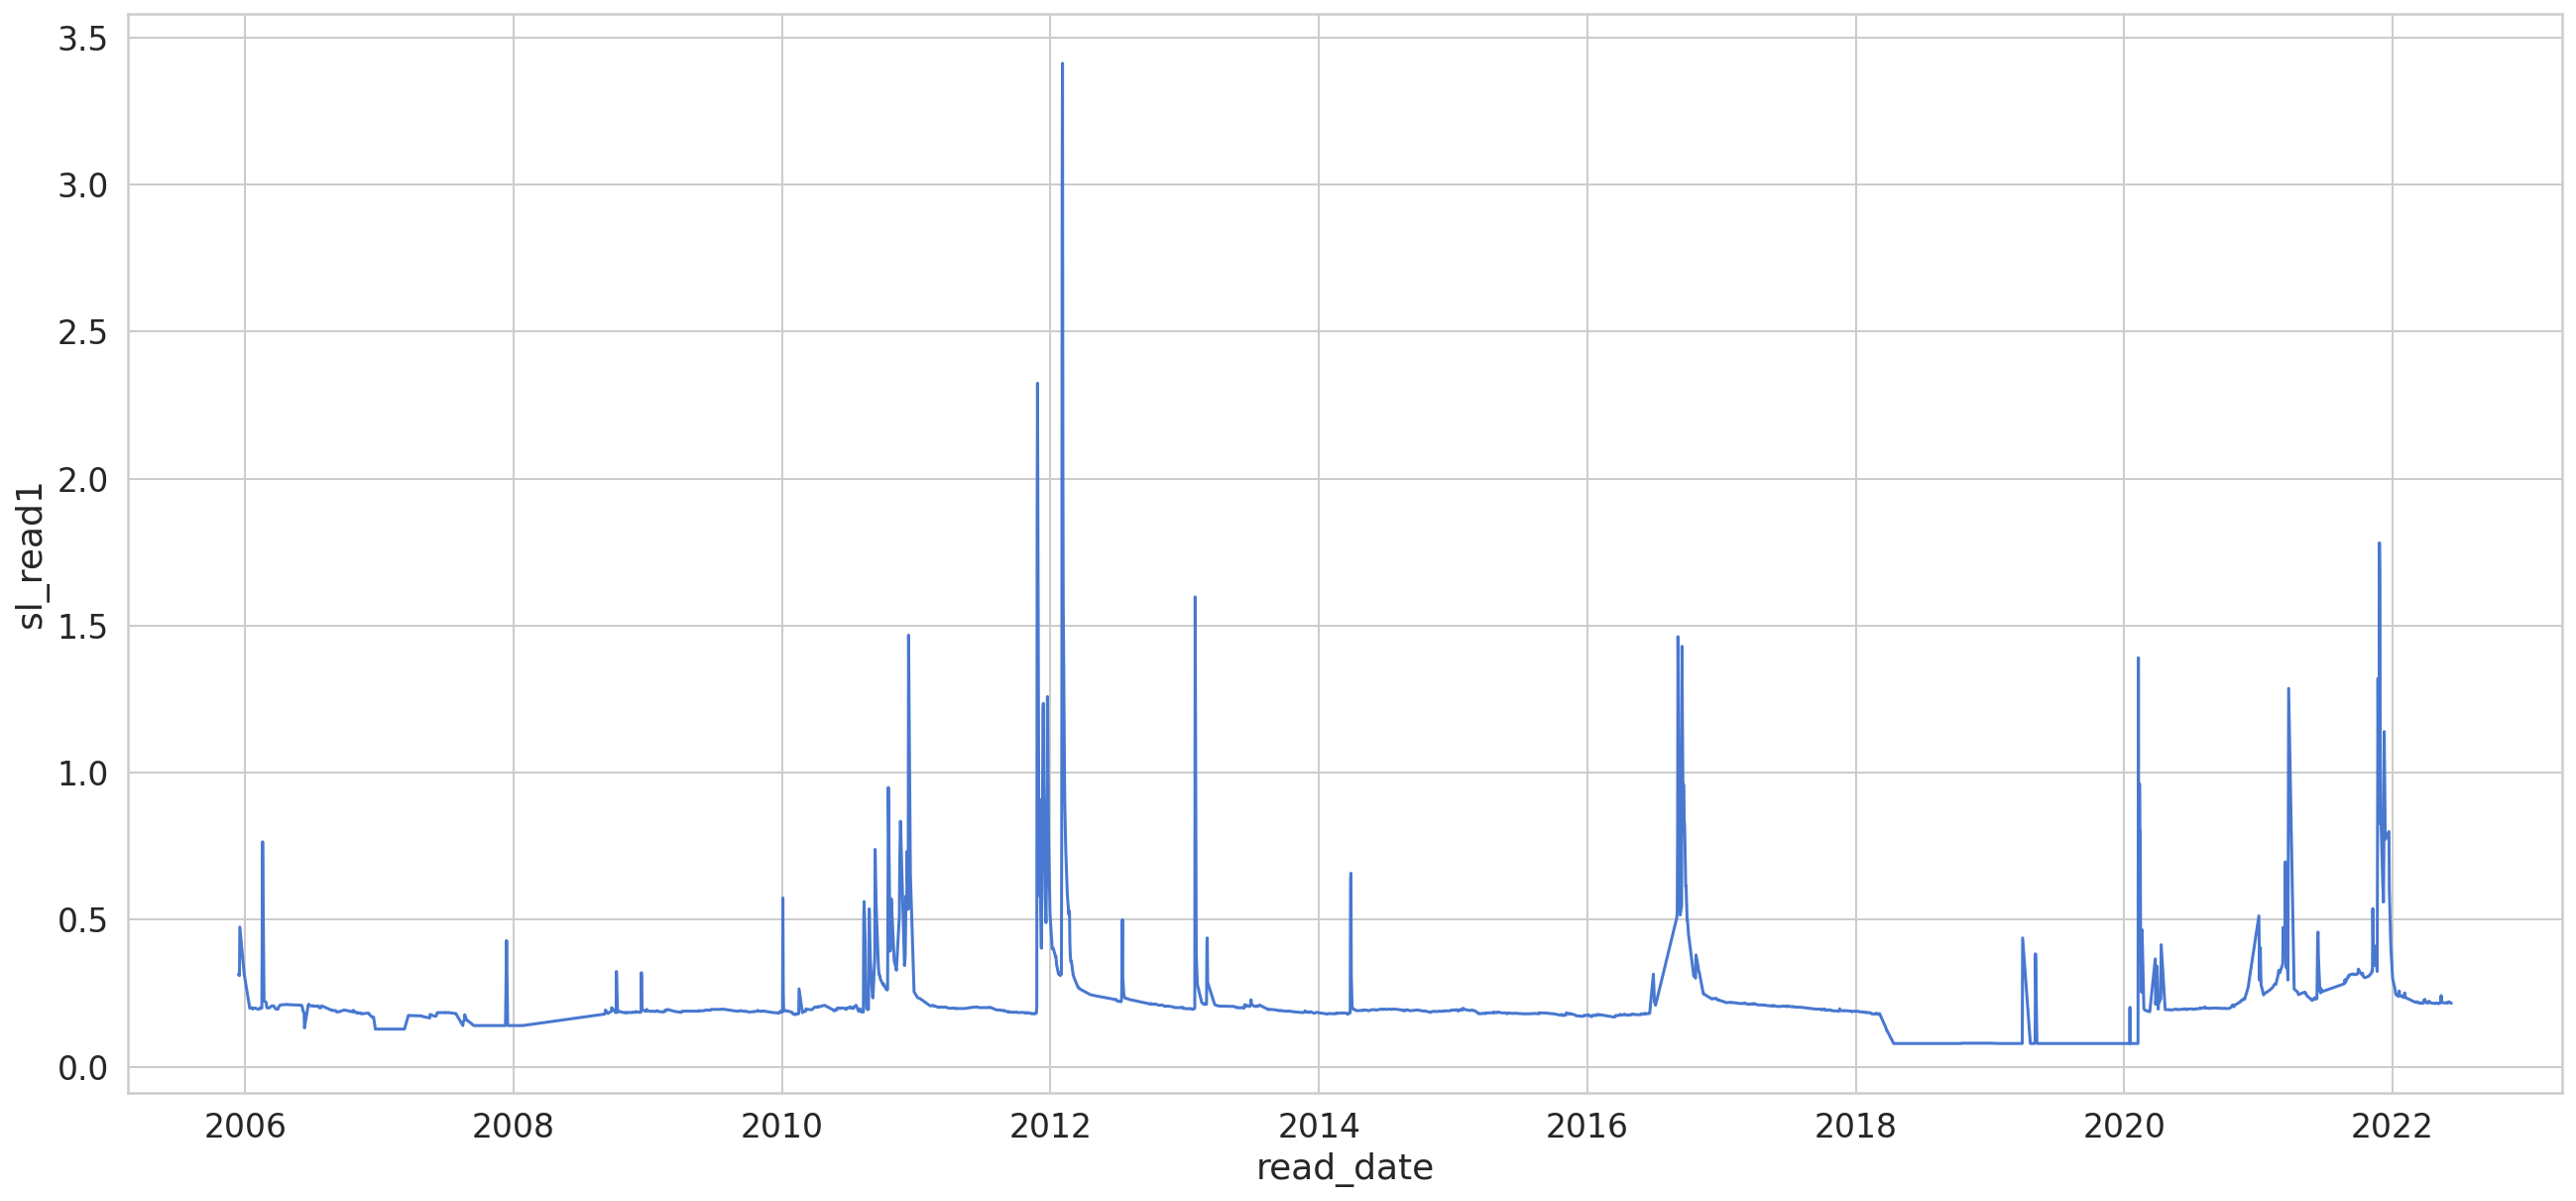

In [26]:
sns.lineplot(x=df.index, y="sl_read1", data=df);

In [27]:

# read_date sl_read1 	bl_ahd1 	mean_temp1 	bl_ahd2 	mean_temp2 	rf_read1
def create_data():
    
    df1 = df.copy()
    df2 = df.copy()
    df2 = df2.drop(['mean_temp1','mean_temp2','rf_read1', 'rf_MA'],axis=1)   #, 'rf_bin'
    
    #df1, df2 = scale_input(df1,df2) 

    return(df1,df2)

In [28]:
def create_train(X,Y):
    train_size = int(len(X) * 0.50)
    X_train, Y_train = X[0:train_size], Y[0:train_size]
#    print(X_train, Y_train)
    return X_train, Y_train

In [29]:
def create_test(X,Y):
    train_size = int(len(X) * 0.50)
    test_size = int(len(X) * 0.75)
    X_test, Y_test = X[train_size:test_size], Y[train_size:test_size]
#    print(X_test, Y_test)
    return X_test, Y_test

In [30]:
def create_model_data(X,Y):
    test_size = int(len(X) * 0.75)
    model_size = int(len(X))
    X_model, Y_model = X[test_size:model_size], Y[test_size:model_size]
#    print(X_test, Y_test)
    return X_model, Y_model

In [31]:
def create_dataset(datax, datay, step):
    X, Y = [], []
    for i in range(len(datax) - step):
        d = i + step  
        X.append(datax[i:d,])
        Y.append(datay[d])
        
    return np.array(X), np.array(Y)

In [32]:
def normalise_dataset(X,Y):

    X, Y = scaler.fit_transform(X), scaler.fit_transform(Y)
    
    return np.array(X), np.array(Y)

In [33]:
time_steps = 10

Xs,Ys = create_data()


Xs_train, Ys_train = create_train(Xs,Ys) 
Xs_test, Ys_test = create_test(Xs,Ys)
Xs_model, Ys_model = create_model_data(Xs,Ys)


Xsn_train, Ysn_train = normalise_dataset(Xs_train,Ys_train)
Xsn_test, Ysn_test = normalise_dataset(Xs_test,Ys_test)
Xsn_model, Ysn_model = normalise_dataset(Xs_model,Ys_model)


X_train, Y_train = create_dataset(Xsn_train,Ysn_train, time_steps)
X_test, Y_test = create_dataset(Xsn_test,Ysn_test, time_steps)
X_model, Y_model = create_dataset(Xsn_model,Ysn_model, time_steps)



# Retain original dataset values as numpy series for visualisations

Xs_train = Xs_train[:(len(Xs_train) - time_steps)].to_numpy()
Ys_train = Ys_train[:(len(Ys_train) - time_steps)].to_numpy()

Xs_test = Xs_test[:(len(Xs_test) - time_steps)].to_numpy()
Ys_test = Ys_test[:(len(Ys_test) - time_steps)].to_numpy()

Xs_model = Xs_model[:(len(Xs_model) - time_steps)].to_numpy()
Ys_model = Ys_model[:(len(Ys_model) - time_steps)].to_numpy()


print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_model.shape, Y_model.shape)

(865, 10, 8) (865, 4)
(427, 10, 8) (427, 4)
(428, 10, 8) (428, 4)


In [34]:
#Model 1
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=3))
model.compile(loss='mean_squared_error', optimizer='adam')

In [19]:
#Model 2

model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2)),
model.add(keras.layers.Dense(units=32, activation='relu')),
model.add(keras.layers.Dropout(rate=0.2)),
model.add(keras.layers.Dense(units=16, activation='relu')),
model.add(keras.layers.Dense(units=3, activation='linear')),
model.compile(loss='mean_squared_error', optimizer='adam')

In [35]:
#Model 1 & 2

history = model.fit(
    X_train, Y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30


ValueError: in user code:

    File "/opt/conda/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.8/site-packages/keras/engine/training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/conda/lib/python3.8/site-packages/keras/engine/training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "/opt/conda/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/conda/lib/python3.8/site-packages/keras/losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "/opt/conda/lib/python3.8/site-packages/keras/losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/conda/lib/python3.8/site-packages/keras/losses.py", line 1327, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 3 and 4 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_2/dense_4/BiasAdd, IteratorGetNext:1)' with input shapes: [?,3], [?,4].


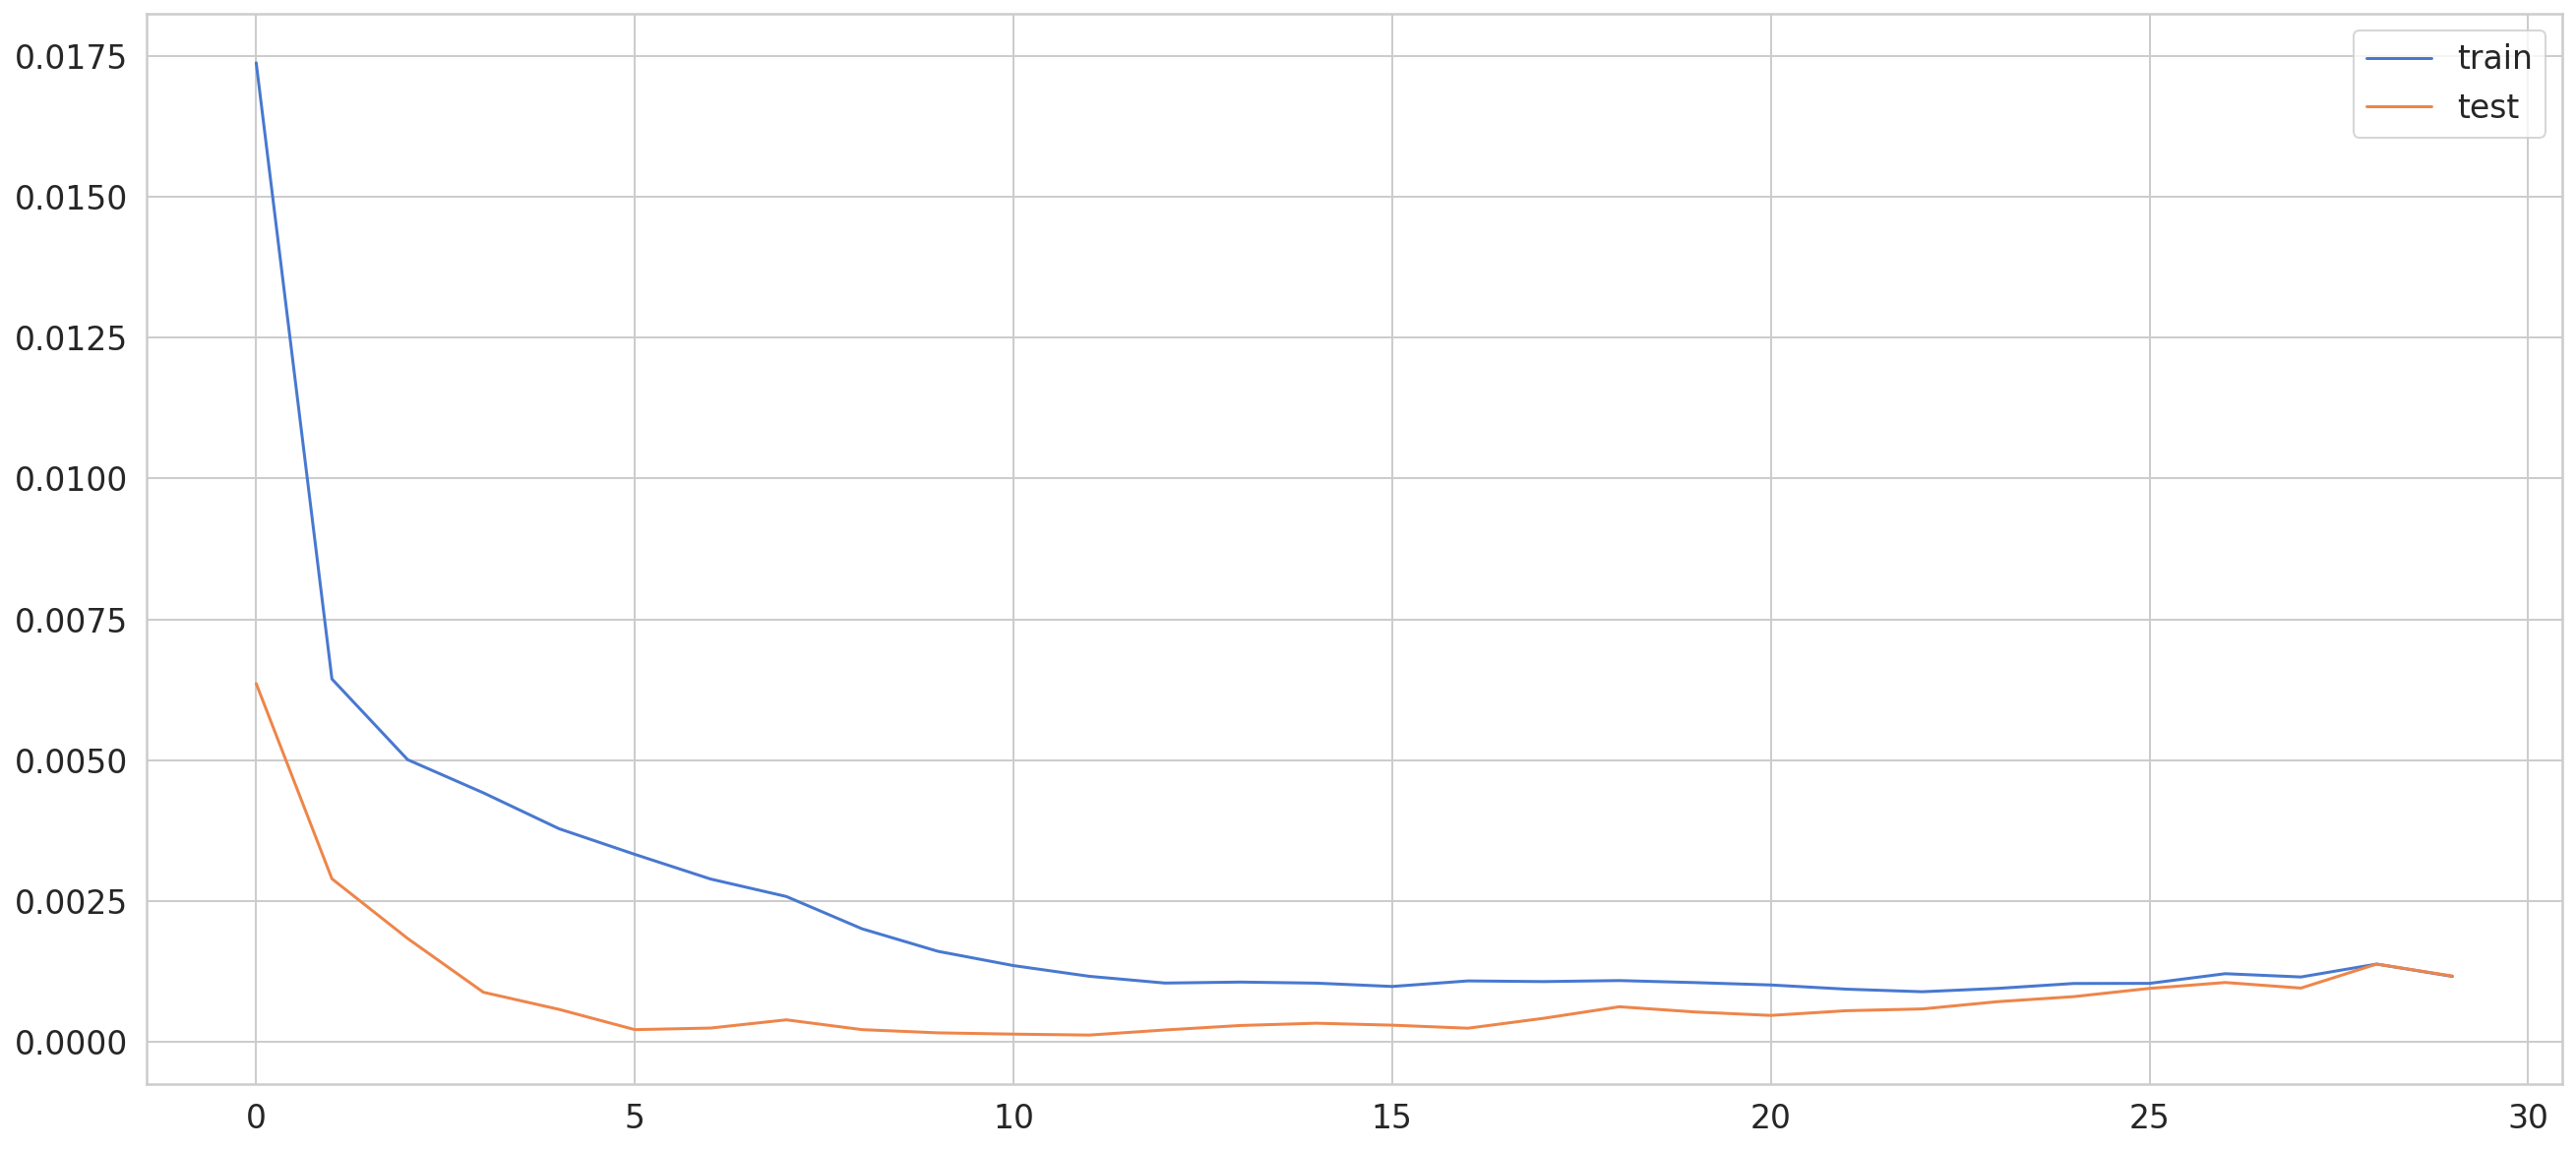

In [218]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [219]:
Y_pred = model.predict(X_test)

In [220]:
Y_train_inv = scaler.inverse_transform(Y_train)
Y_test_inv = scaler.inverse_transform(Y_test)
Y_pred_inv = scaler.inverse_transform(Y_pred)


In [221]:
#print(Y_pred_inv)
#print(Y_pred_inv.shape)
#print(Y_train_inv)
#print(Y_train_inv.shape)
#print(Ys_test)
#print(Ys_test.shape)
#print(Y_test_inv)
#print(Y_test_inv.shape)
# #2005-12-02     0.295  253.271  251.641

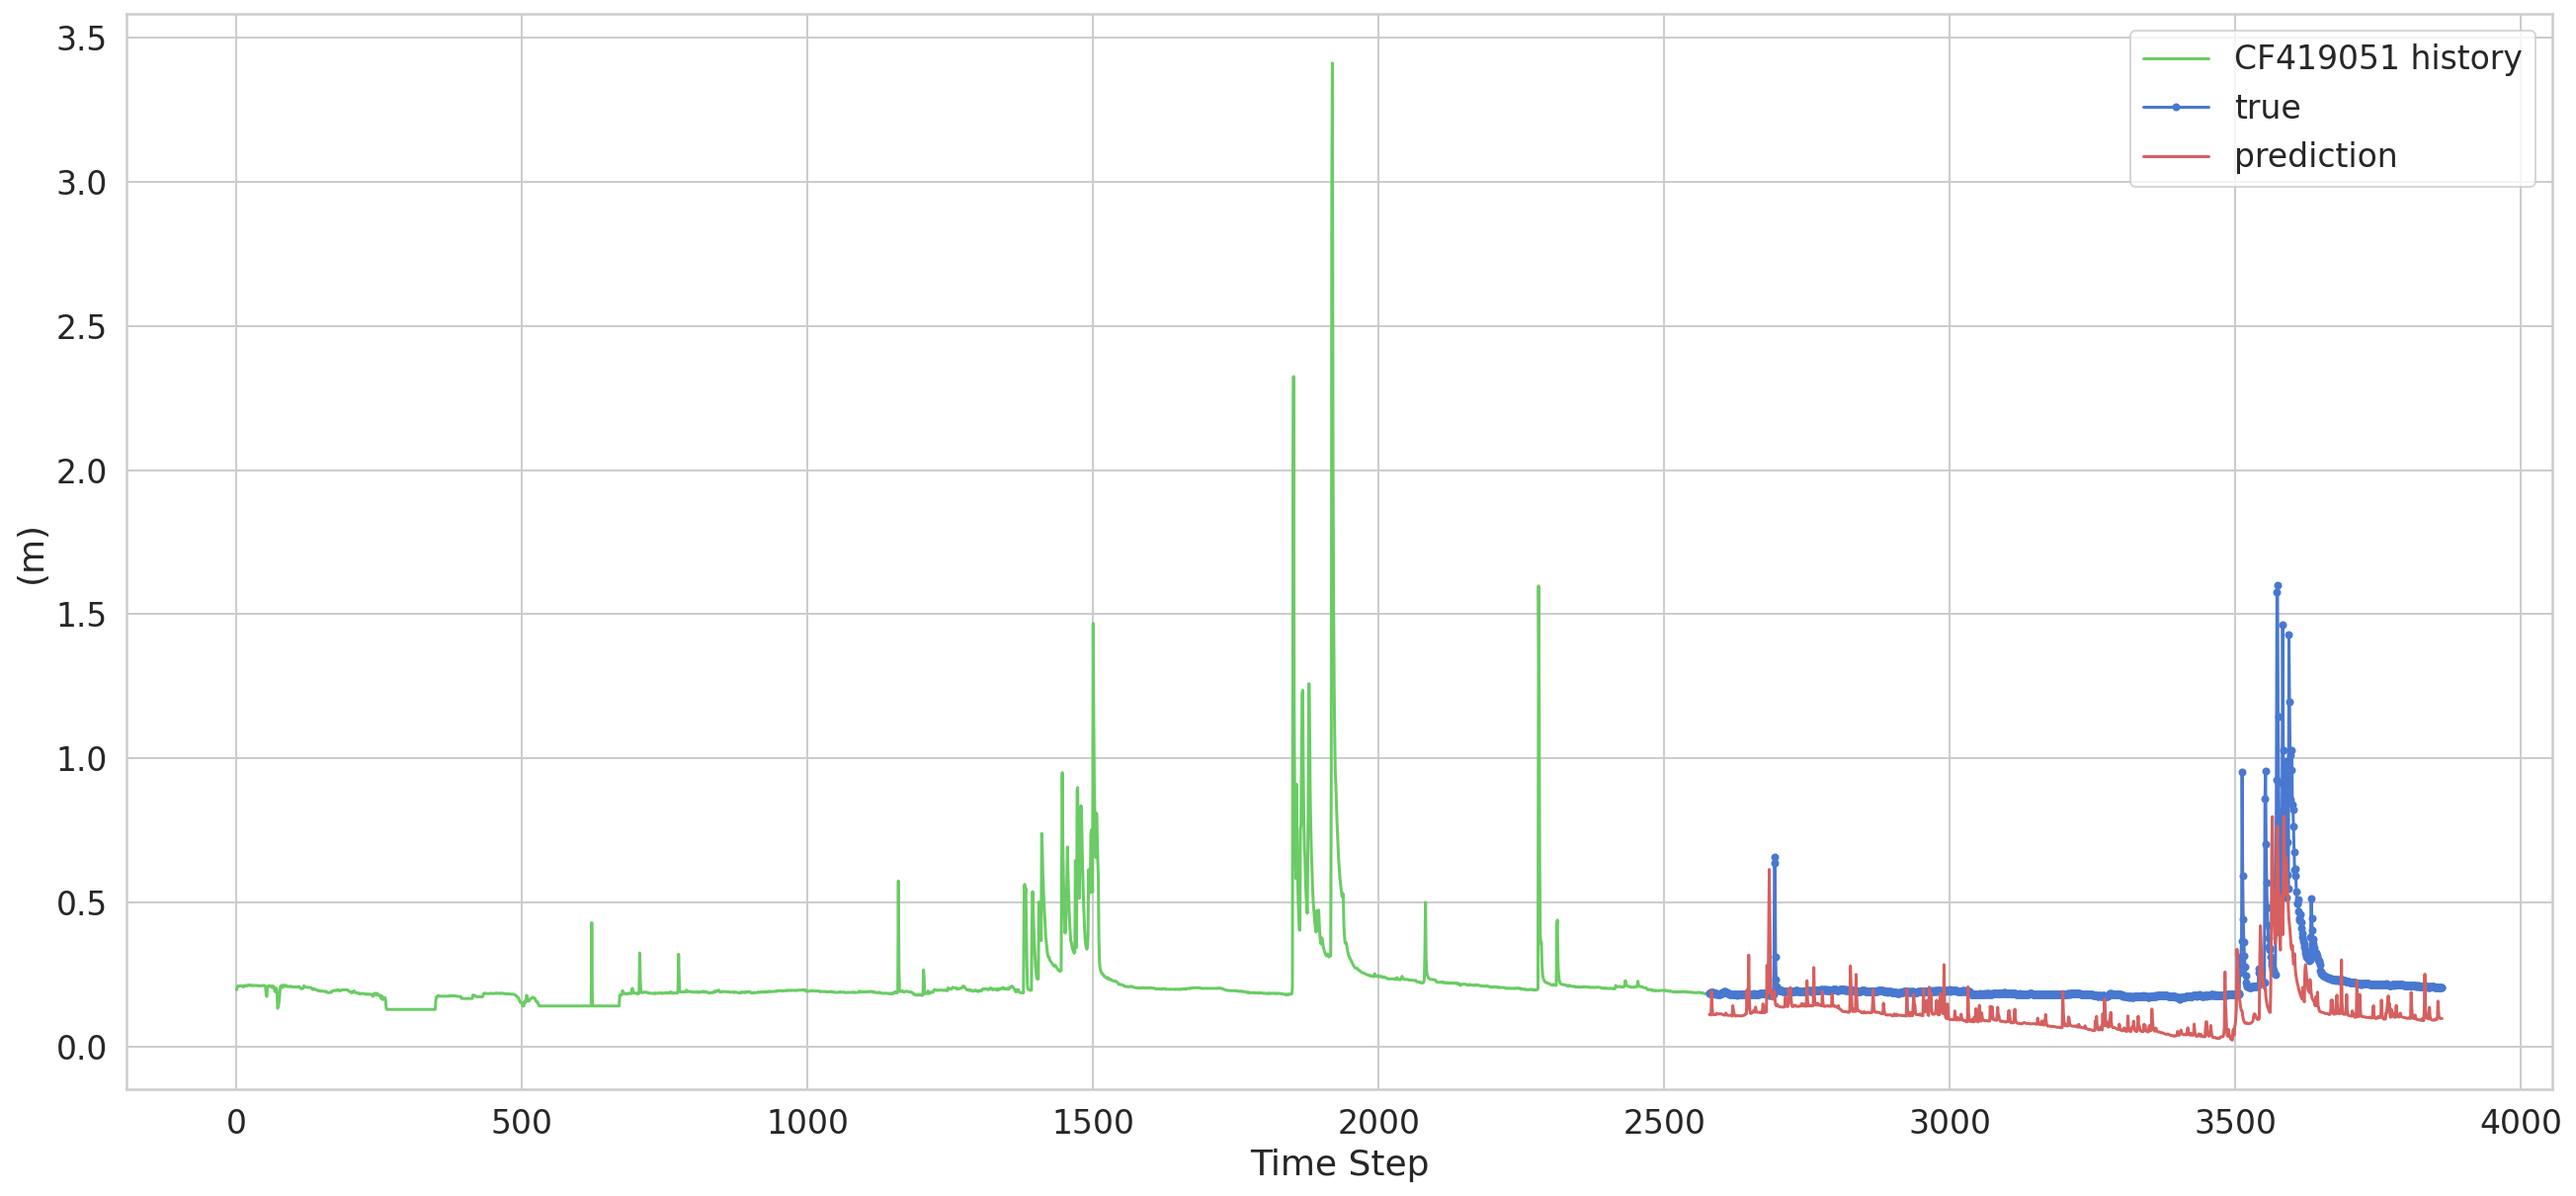

In [222]:
plt.plot(np.arange(0, len(Y_train)), Ys_train[:,0].flatten(), 'g', label="CF419051 history")
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), Ys_test[:,0].flatten(), marker='.', label="true")
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), Y_pred_inv[:,0].flatten(), 'r', label="prediction")
plt.ylabel('(m)')
plt.xlabel('Time Step')
plt.legend()
plt.show();

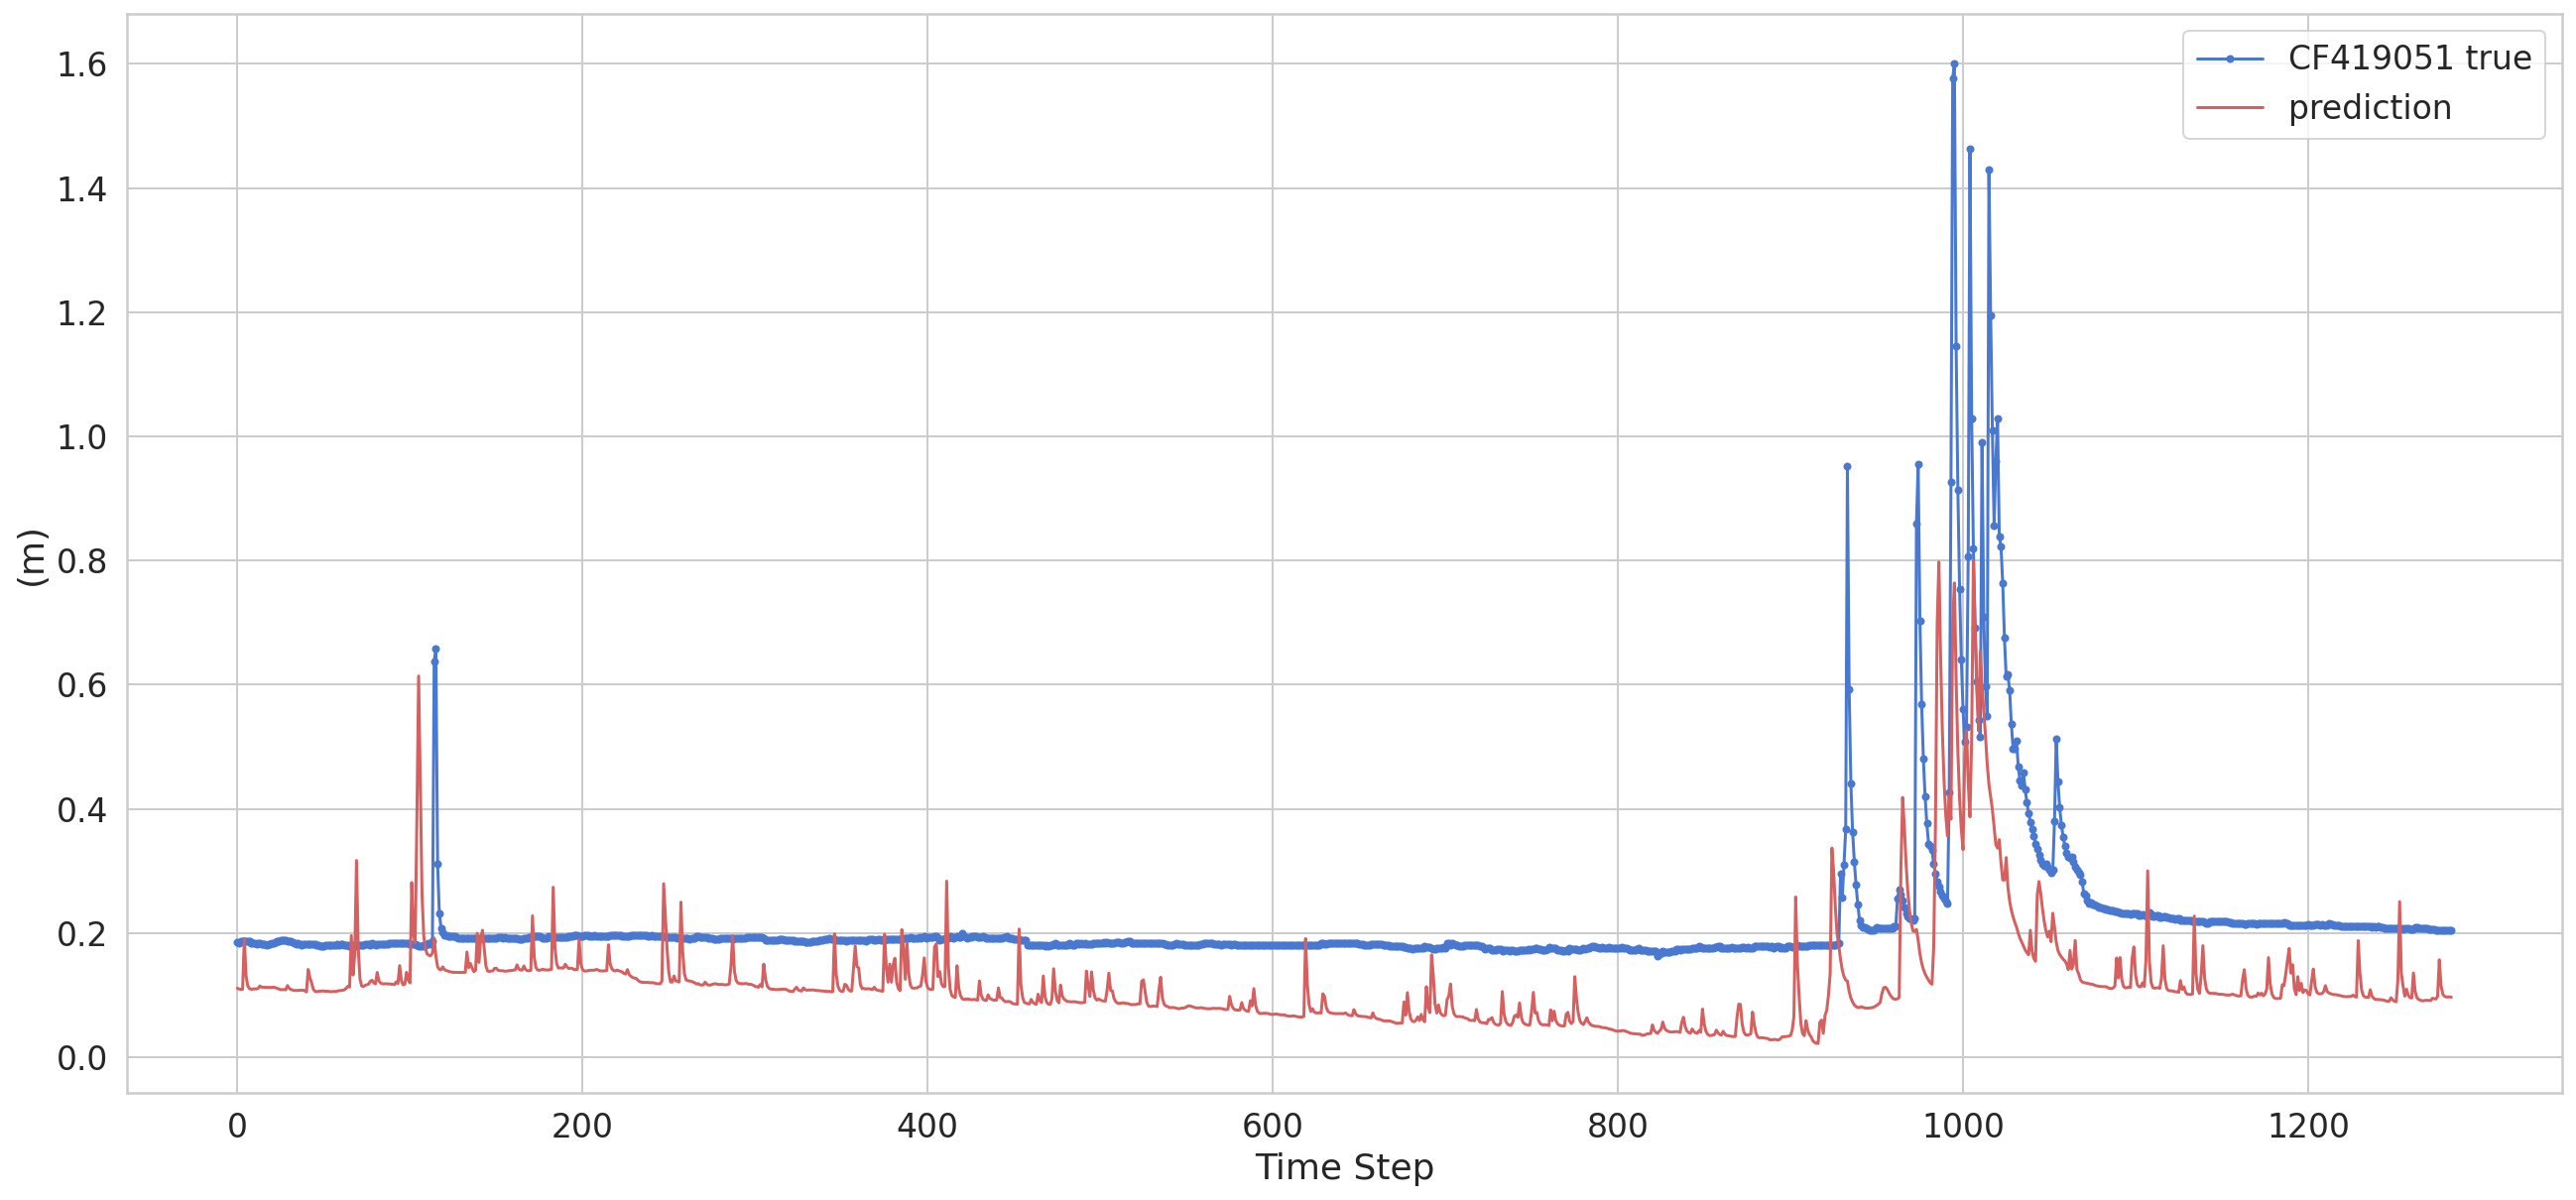

In [223]:
plt.plot(Ys_test[:,0].flatten(), marker='.', label="CF419051 true")
plt.plot(Y_pred_inv[:,0].flatten(), 'r', label="prediction")
plt.ylabel('(m)')
plt.xlabel('Time Step')
plt.legend()
plt.show();

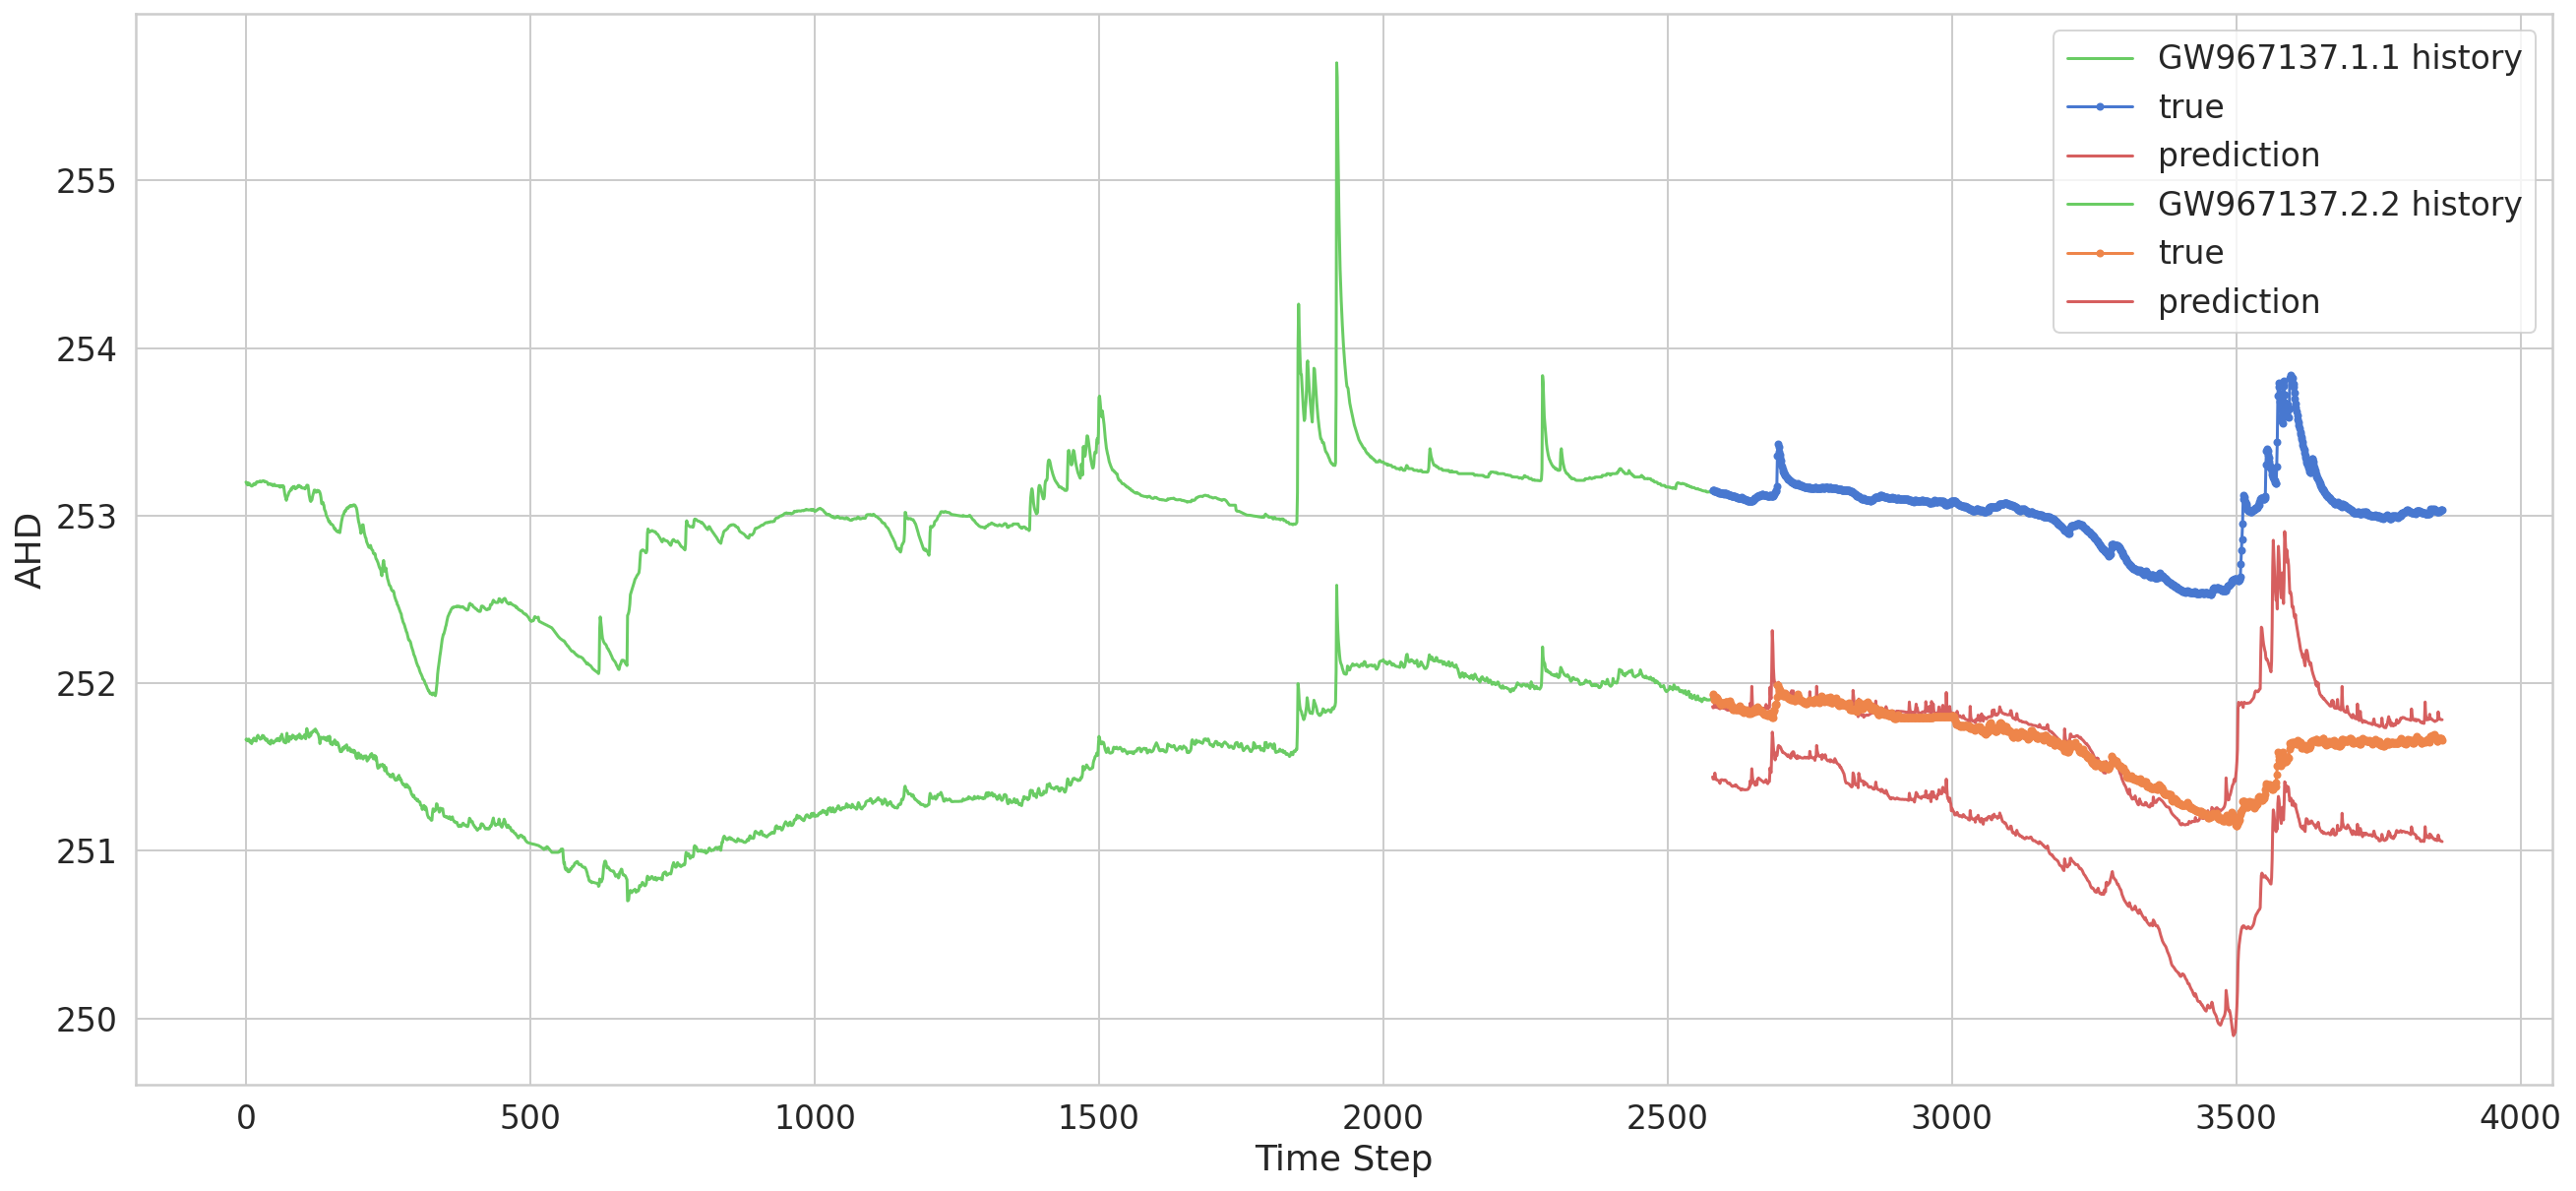

In [229]:
plt.plot(np.arange(0, len(Y_train)), Ys_train[:,1].flatten(), 'g', label="GW967137.1.1 history")
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), Ys_test[:,1].flatten(), marker='.', label="true")
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), Y_pred_inv[:,1].flatten(), 'r', label="prediction")

plt.plot(np.arange(0, len(Y_train)), Ys_train[:,2].flatten(), 'g', label="GW967137.2.2 history")
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), Ys_test[:,2].flatten(), marker='.', label="true")
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), Y_pred_inv[:,2].flatten(), 'r', label="prediction")
plt.ylabel('AHD')
plt.xlabel('Time Step')
plt.legend()
plt.show();

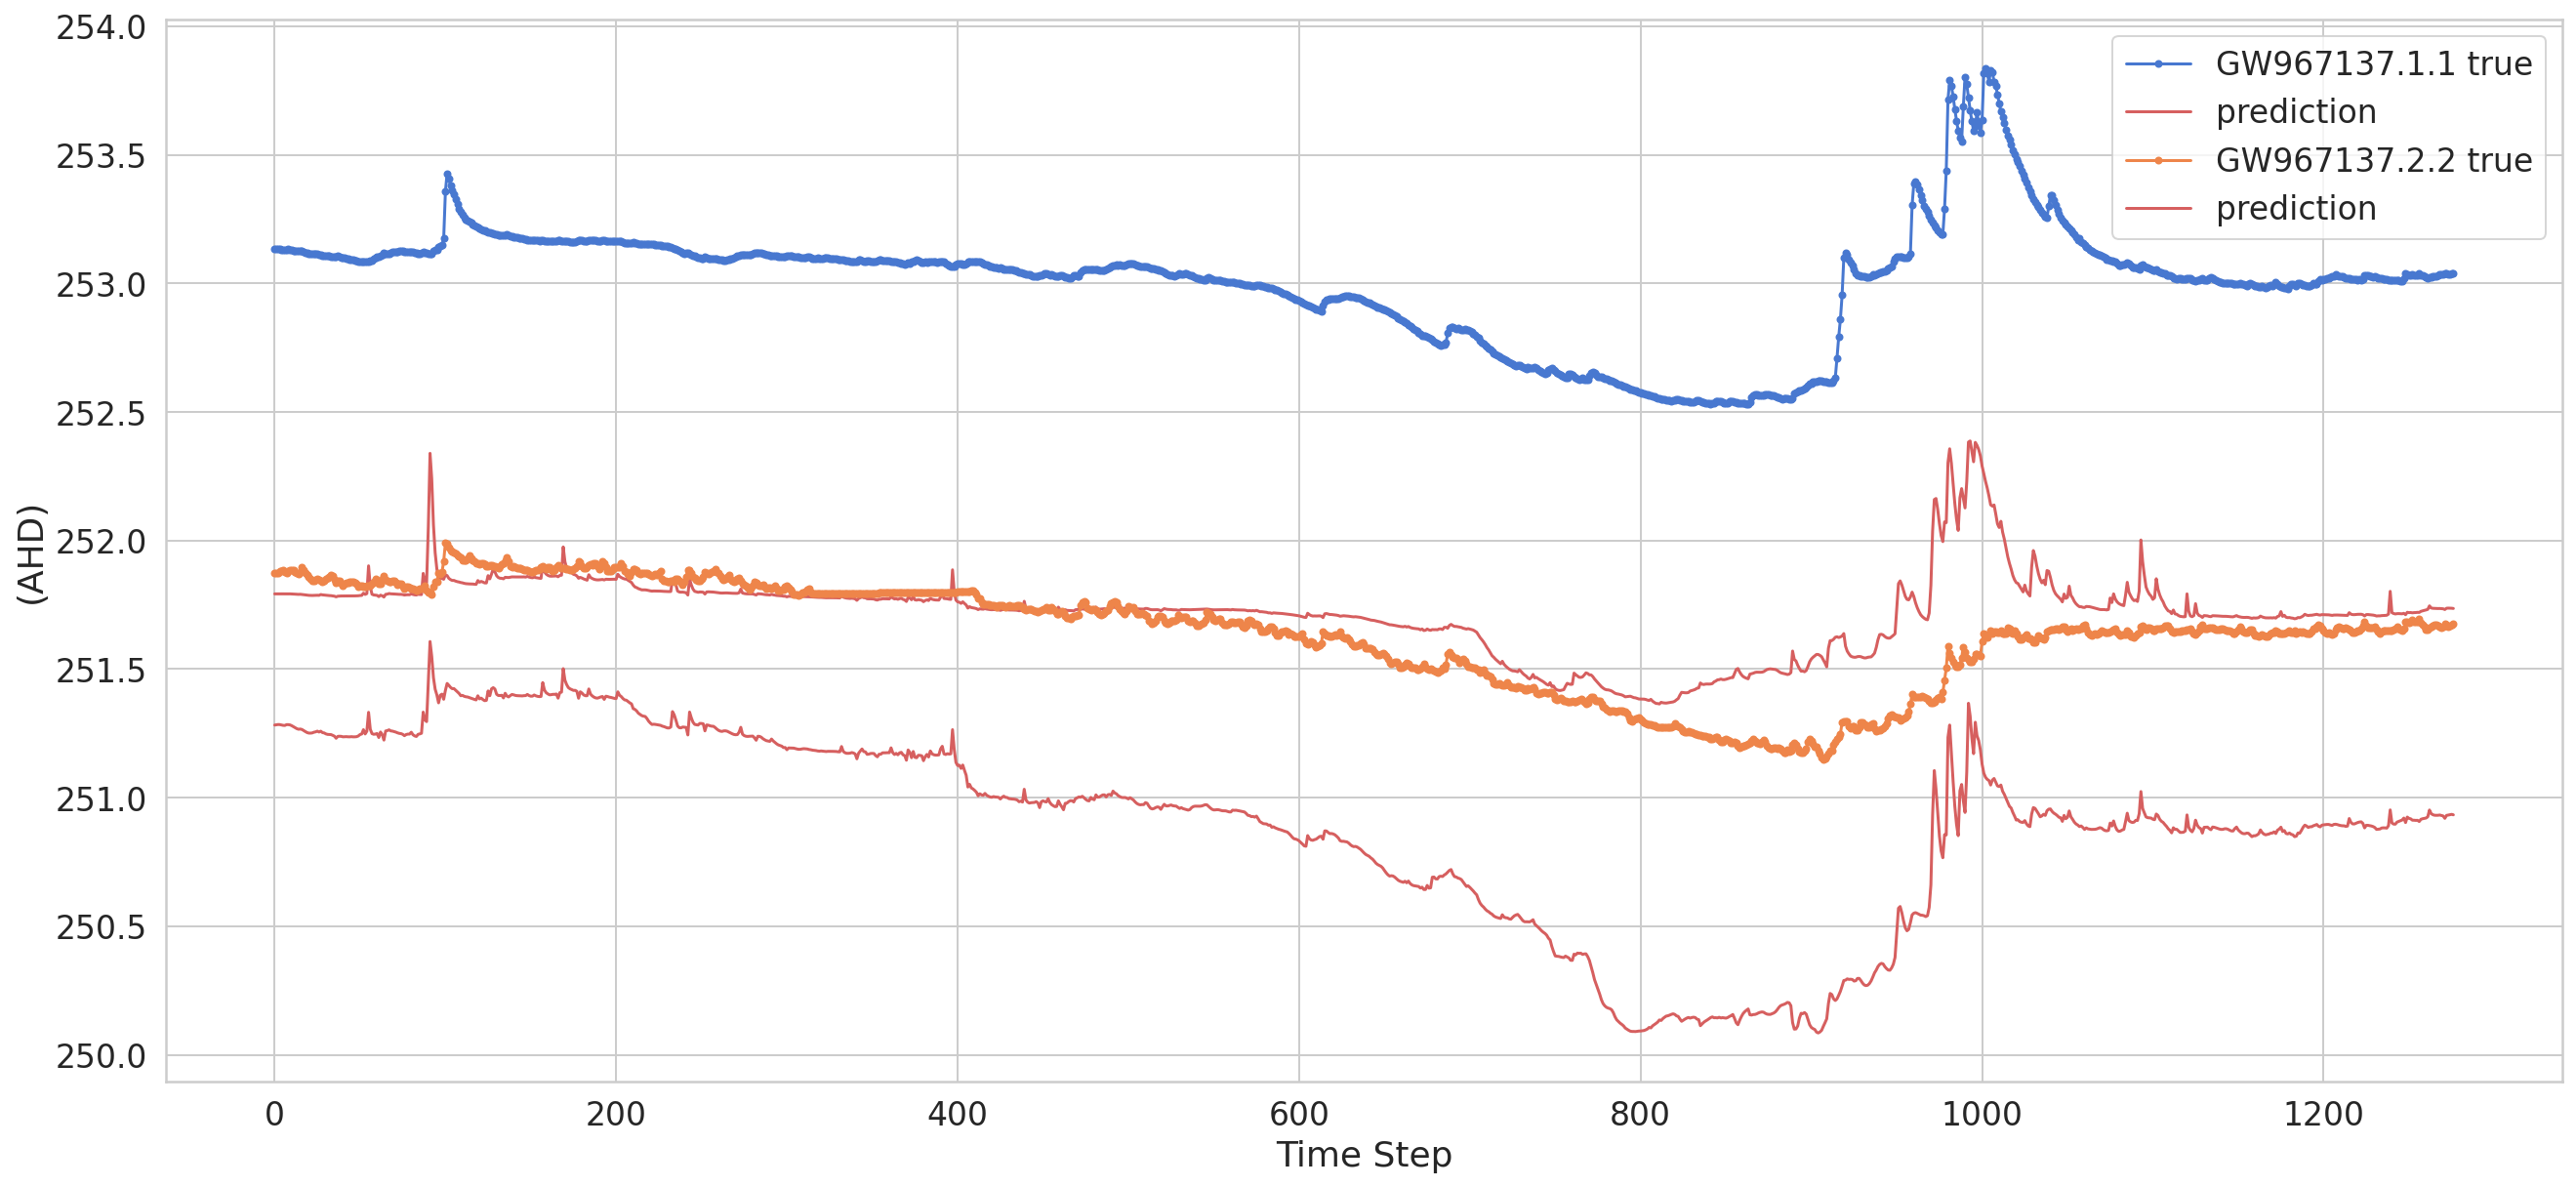

In [189]:
plt.plot(Ys_test[:,1].flatten(), marker='.', label="GW967137.1.1 true")
plt.plot(Y_pred_inv[:,1].flatten(), 'r', label="prediction")
plt.plot(Ys_test[:,2].flatten(), marker='.', label="GW967137.2.2 true")
plt.plot(Y_pred_inv[:,2].flatten(), 'r', label="prediction")
plt.ylabel('(AHD)')
plt.xlabel('Time Step')
plt.legend()
plt.show();

# Modelled Data

In [190]:
Y_pred = model.predict(X_model)

In [191]:
Y_model_pred_inv = scaler.inverse_transform(Y_pred)


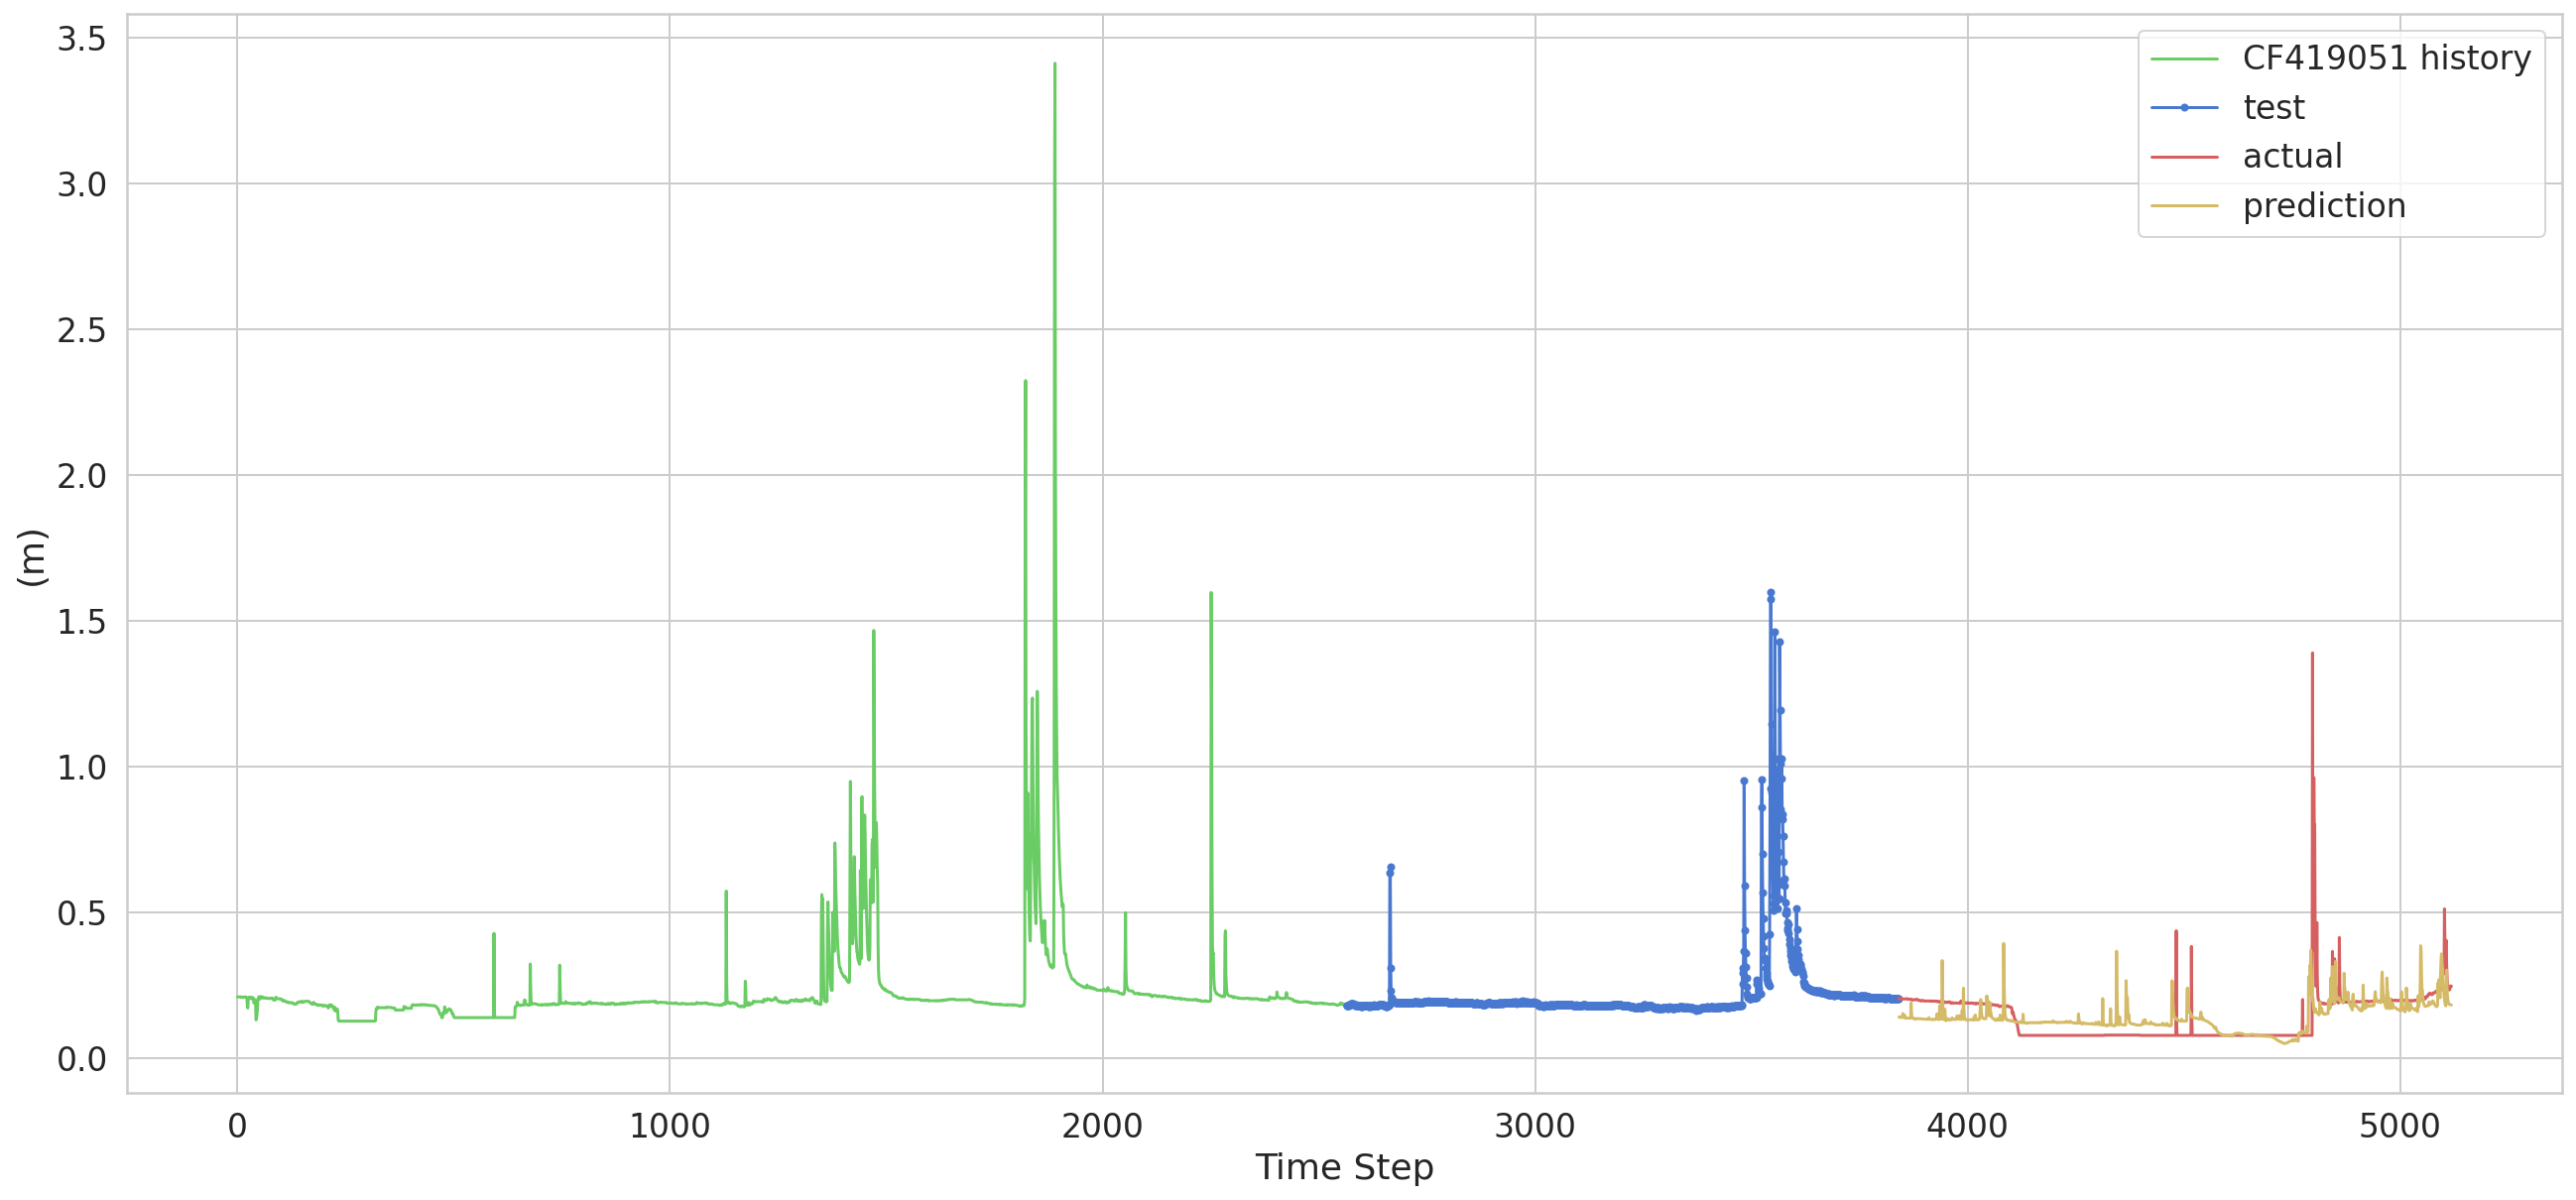

In [192]:
plt.plot(np.arange(0, len(Y_train)), Ys_train[:,0].flatten(), 'g', label="CF419051 history")
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), Ys_test[:,0].flatten(), marker='.', label="test")
plt.plot(np.arange(len(Y_train)  + len(Y_test), len(Y_train) + len(Y_test) + len(Ys_model)), Ys_model[:,0].flatten(), 'r', label="actual")
plt.plot(np.arange(len(Y_train) + len(Y_test), len(Y_train) + len(Y_test) + len(Y_model)), Y_model_pred_inv[:,0].flatten(), 'y', label="prediction")


plt.ylabel('(m)')
plt.xlabel('Time Step')
plt.legend()
plt.show();

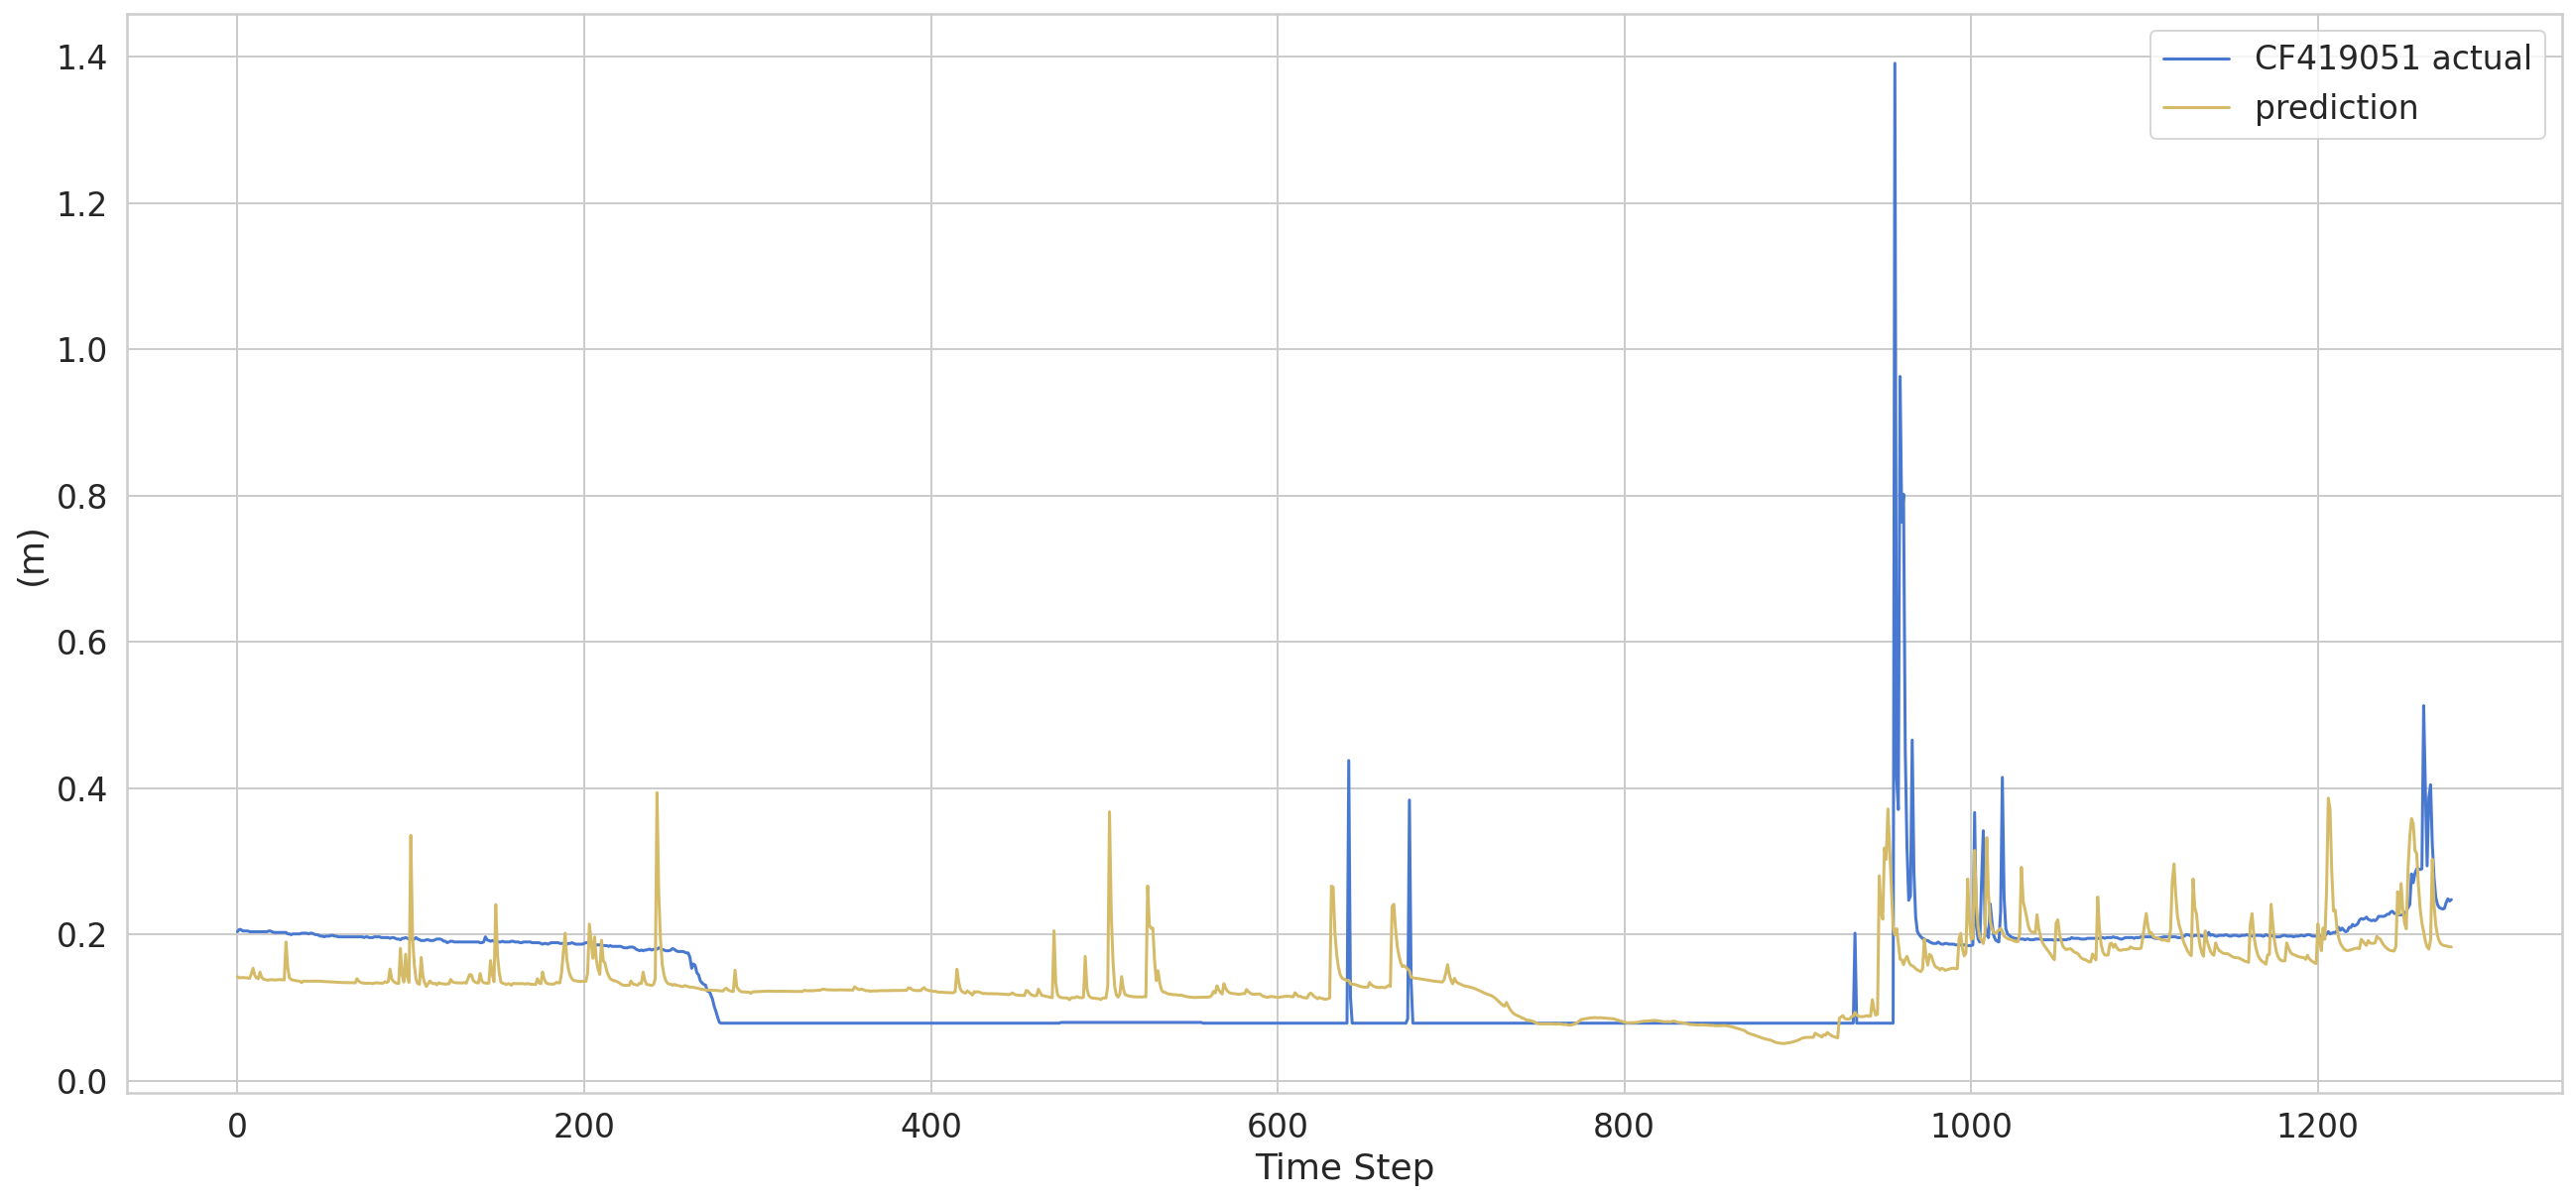

In [193]:
plt.plot(Ys_model[:,0].flatten(), label="CF419051 actual")
plt.plot(Y_model_pred_inv[:,0].flatten(), 'y', label="prediction")
plt.ylabel('(m)')
plt.xlabel('Time Step')
plt.legend()
plt.show();

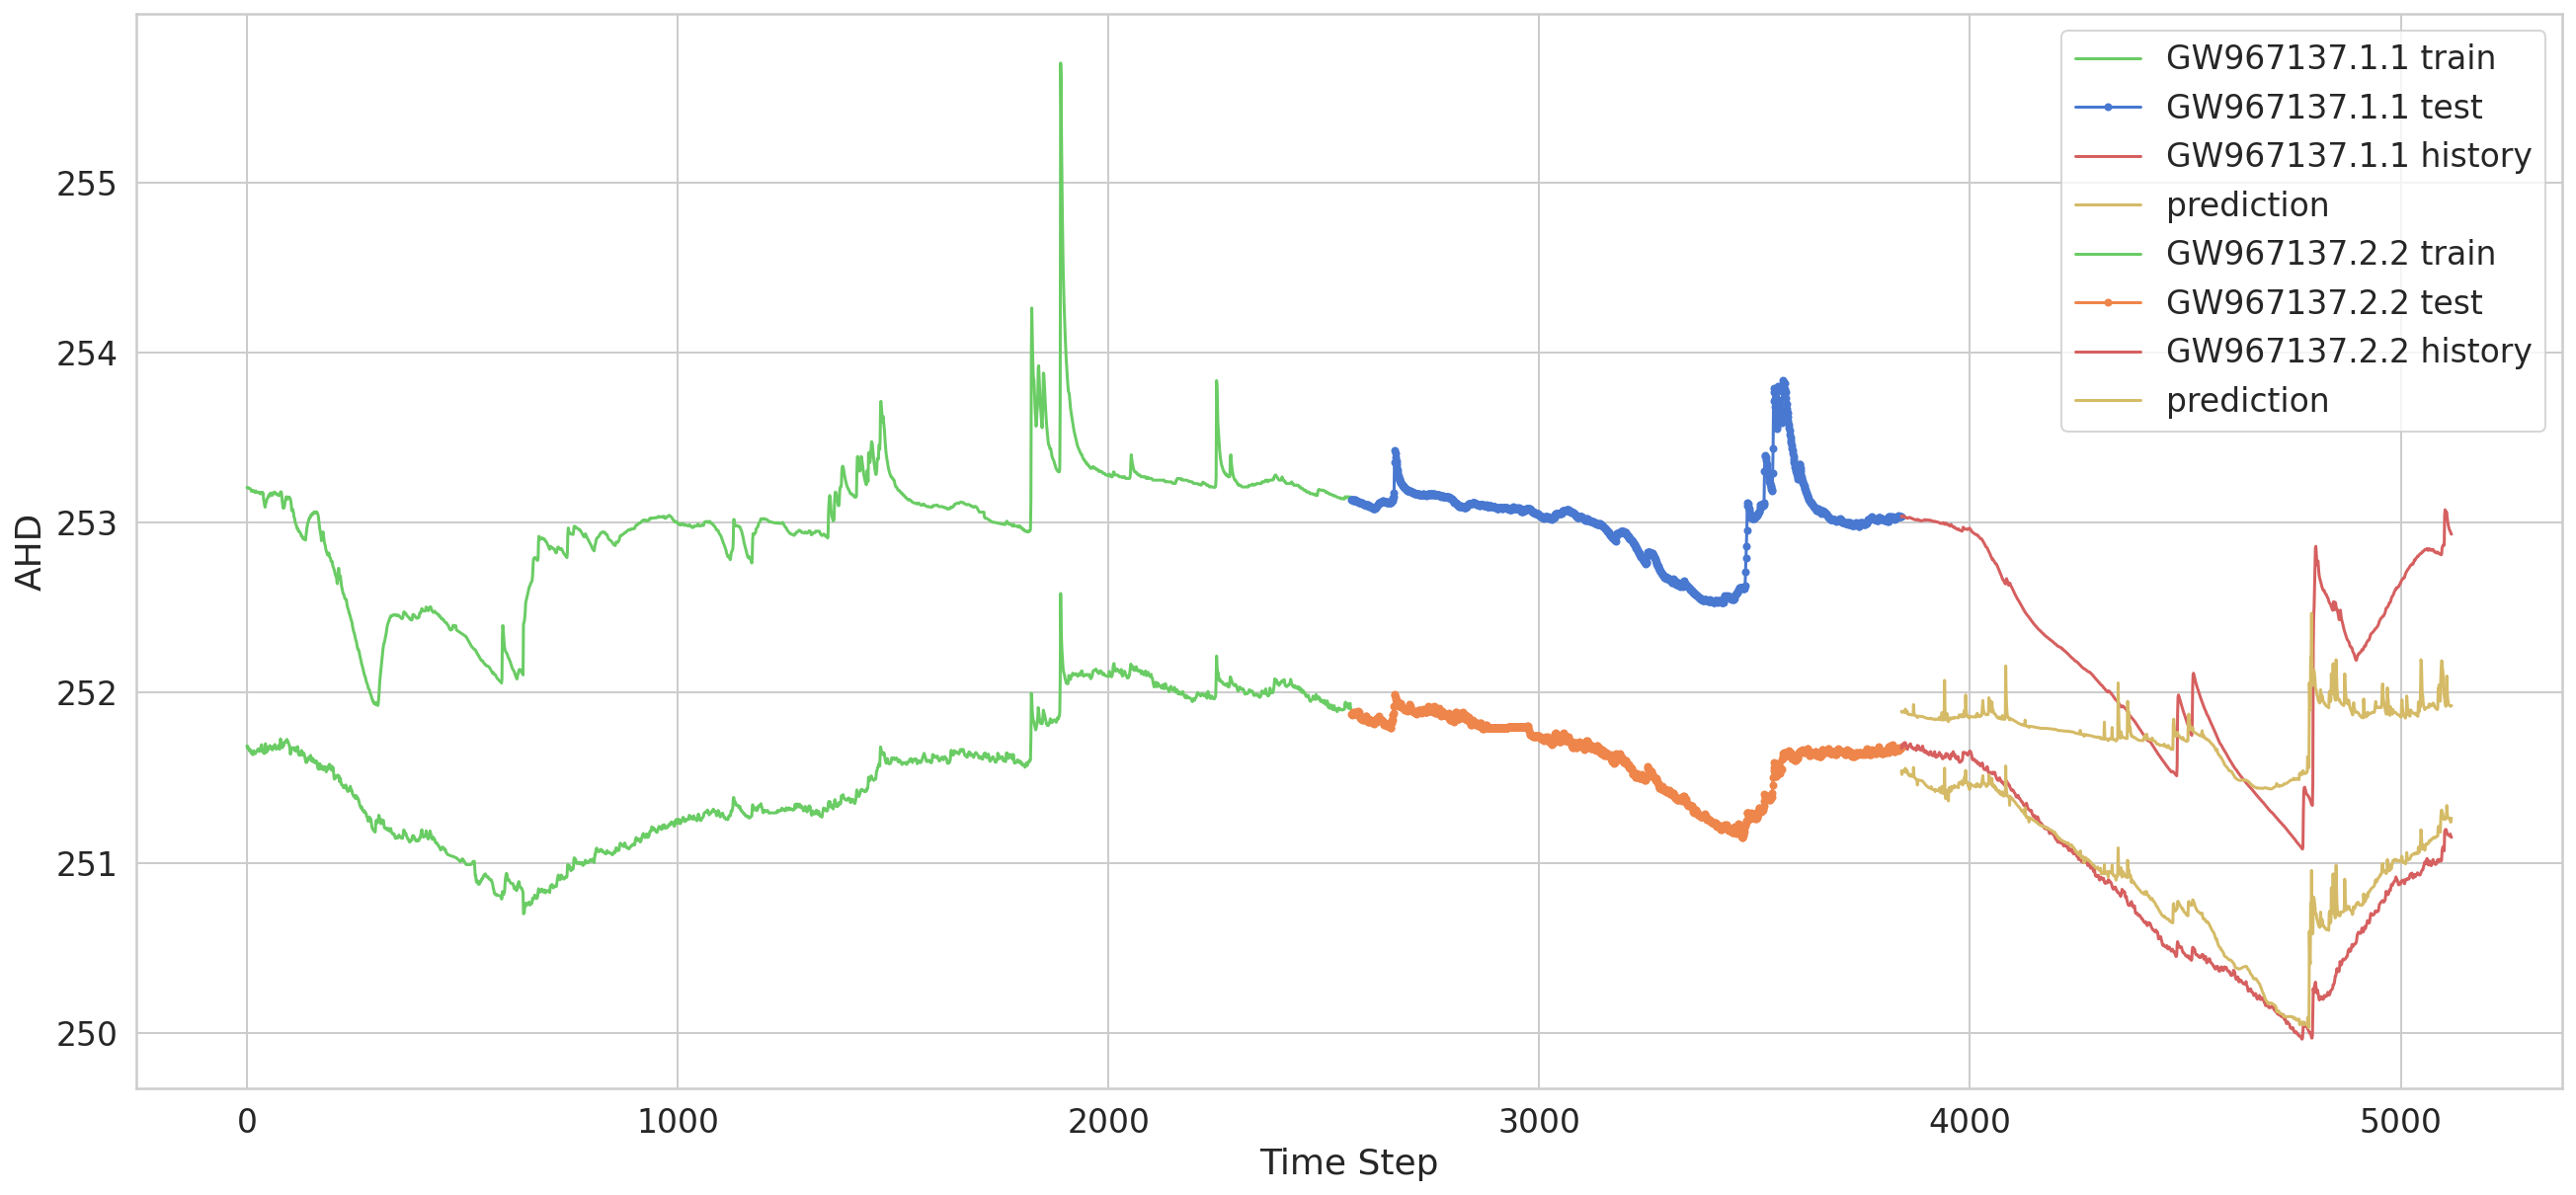

In [194]:
plt.plot(np.arange(0, len(Y_train)), Ys_train[:,1].flatten(), 'g', label="GW967137.1.1 train")
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), Ys_test[:,1].flatten(), marker='.', label="GW967137.1.1 test")
plt.plot(np.arange(len(Y_train) + len(Y_test), len(Y_train) + len(Y_test) + len(Y_model)), Ys_model[:,1].flatten(), 'r', label="GW967137.1.1 history")
plt.plot(np.arange(len(Y_train) + len(Y_test), len(Y_train) + len(Y_test) + len(Y_model)), Y_model_pred_inv[:,1].flatten(), 'y', label="prediction")

plt.plot(np.arange(0, len(Y_train)), Ys_train[:,2].flatten(), 'g', label="GW967137.2.2 train")
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), Ys_test[:,2].flatten(), marker='.', label="GW967137.2.2 test")
plt.plot(np.arange(len(Y_train) + len(Y_test), len(Y_train) + len(Y_test) + len(Y_model)), Ys_model[:,2].flatten(), 'r', label="GW967137.2.2 history")
plt.plot(np.arange(len(Y_train) + len(Y_test), len(Y_train) + len(Y_test) + len(Y_model)), Y_model_pred_inv[:,2].flatten(), 'y', label="prediction")

plt.ylabel('AHD')
plt.xlabel('Time Step')
plt.legend()
plt.show();

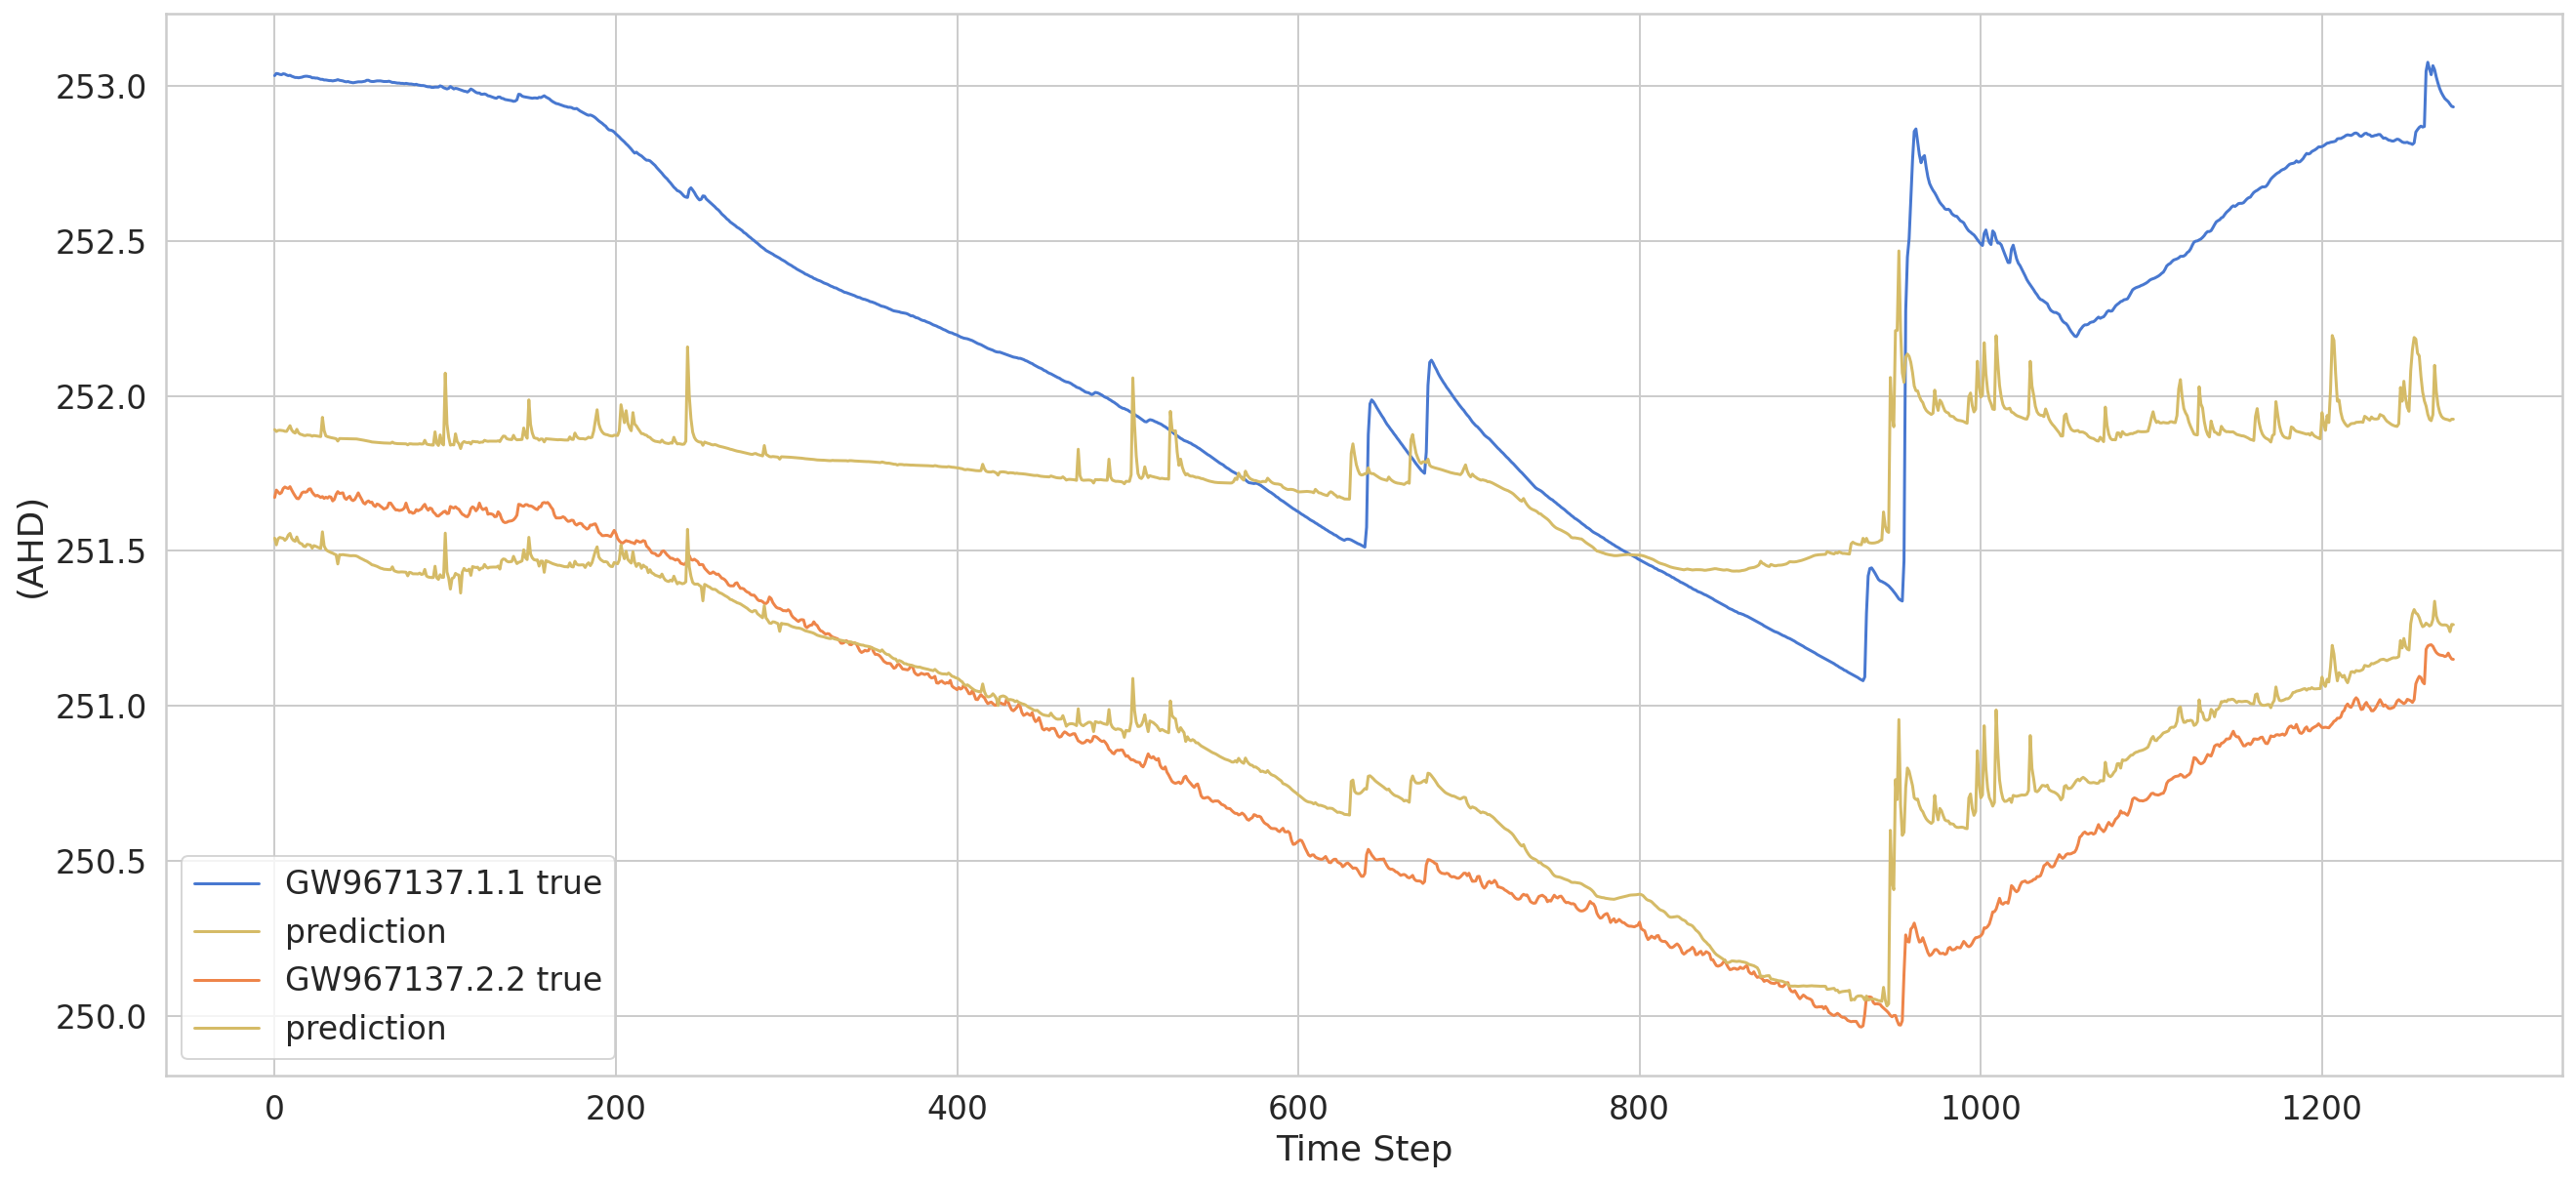

In [195]:

plt.plot(Ys_model[:,1].flatten(), label="GW967137.1.1 true")
plt.plot(Y_model_pred_inv[:,1].flatten(), 'y', label="prediction")

plt.plot(Ys_model[:,2].flatten(), label="GW967137.2.2 true")
plt.plot(Y_model_pred_inv[:,2].flatten(), 'y', label="prediction")

plt.ylabel('(AHD)')
plt.xlabel('Time Step')
plt.legend()
plt.show();